In [17]:

import json
import numpy as np

from datetime import datetime

from scipy import stats


# %config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mplTicker
import matplotlib.style as mplstyle
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

mplstyle.use('fast')
mplstyle.use('default')
# mpl.rcParams['figure.figsize'] = [20, 10]

colors = ["green", "blue", "red"]
cmap = LinearSegmentedColormap.from_list("mycmap", colors)






In [5]:
h = []
id = 0
for i in range(3):
    delta0 = datetime.now()
    with open("G:/Uni/BA/data/history_data_{:02d}_{:02d}.json".format(id, i), "r") as f:
        h.append(json.load(f))
    delta1 = datetime.now()
    print("finished load after", delta1-delta0)
len(h)

xlabels=[
      # "MFs vs MFs",
      # "Ss vs Ss",
      "SDRs vs SDRs",
      "Ss vs MFs",
      "Ss vs SDRs",
      "SDRs vs MFs",
      "MFs vs SDRs",
      ]

finished load after 0:00:30.942447
finished load after 0:00:33.212508
finished load after 0:00:31.682266


In [6]:
gl = [[x["gameLength"] for x in h_] for h_ in h]
gl_stacked = [[(i,gl_.count(i)) for i in range(np.min(gl_),np.max(gl_)+1)] for gl_ in gl]
[[(i,gl_.count(i)) for i in range(np.min(gl_),np.max(gl_)+1)].count(0) for gl_ in gl]

# gl_stacked
# np.average(gl)
# np.min(gl)
# np.max(gl)


[0, 0, 0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


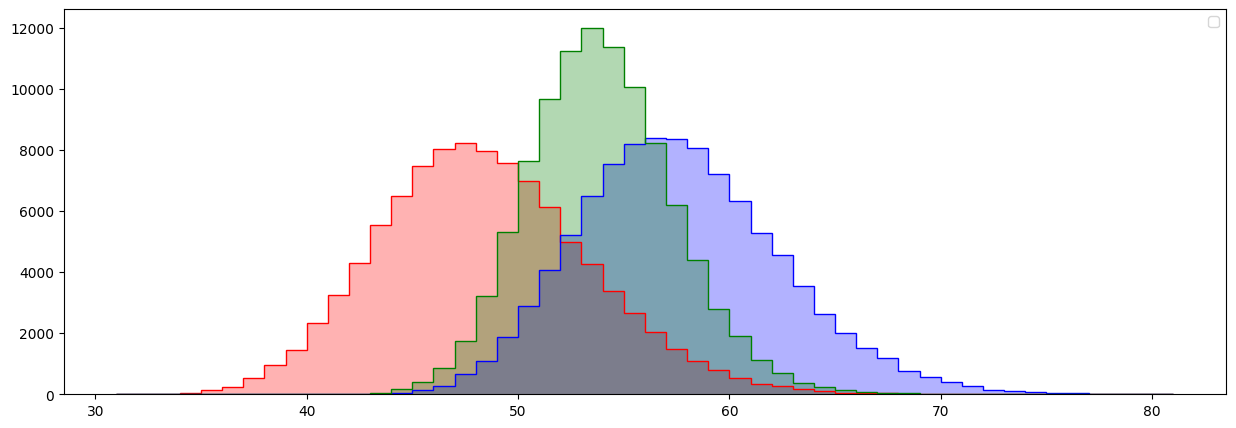

In [19]:
fig, ax = plt.subplots(figsize=[15, 5])

# for i,gl_stacked_ in enumerate(gl_stacked):
#         ax.bar([x for x, _ in gl_stacked_], [
#                 y for _, y in gl_stacked_], alpha=0.5, label=xlabels[i])
#         # ax.plot(gl[i], alpha=0.5)
ax.hist(gl,color=colors,histtype="step",bins=range(min(min(gl)),max(max(gl))))
ax.hist(gl, color=colors,histtype="stepfilled", alpha=.3, bins=range(min(min(gl)), max(max(gl))))
plt.legend()

In [ ]:
[{"strats":[s.getName() for s in gs[i].getStrategies()],"min":np.min(gl_),"median":np.median(gl_),"avg":np.average(gl_),"max":np.max(gl_)} for i,gl_ in enumerate(gl)]

NameError: name 'gs' is not defined

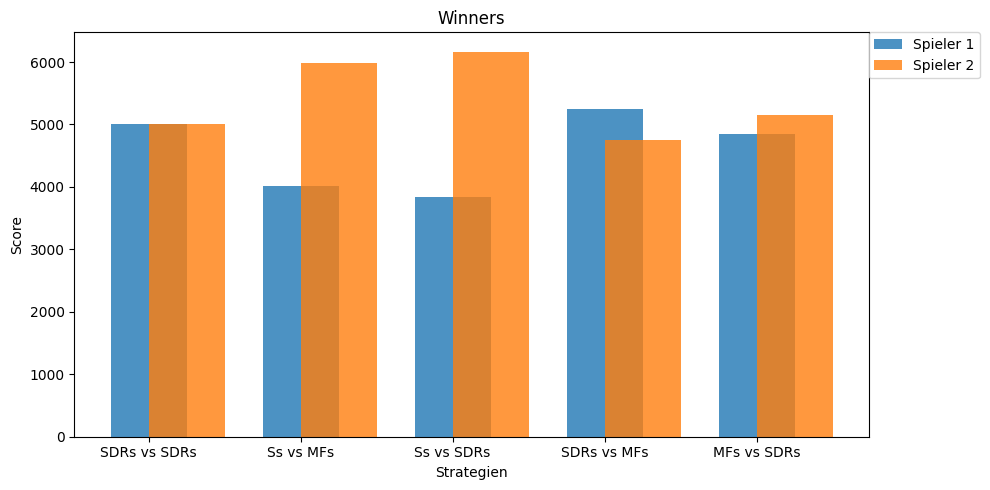

In [ ]:
# xlabels = ['No Influence', 'fight', 'fight incl. double']
# xlabels = ["MultiD2Dice(4)",
# "MultiD2Dice(3)",
# "MultiD2DiceNo0(3)",
# "D4()"]
# xlabels=["MF vs MF","S vs MF","S vs S"]
player0 = [[[p.getID() for p in g["winner"]]for g in s].count([0])for s in h]
player1 = [[[p.getID() for p in g["winner"]]for g in s].count([1])for s in h]

fig, ax = plt.subplots(figsize=[10,5])
# hat_graph(ax, xlabels, [player0, player1], ['Player 0', 'Player 1'])

ax.bar(xlabels,player0,label="Spieler 1", alpha=.8,width=.5)
ax.bar(xlabels,player1,label="Spieler 2", alpha=.8,width=.5,align="edge")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Strategien')
ax.set_ylabel('Score')
ax.set_title('Winners')
ax.legend( bbox_to_anchor=(1, 1),
          loc='upper left', borderaxespad=0.)

fig.tight_layout()
plt.show()
